In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, multivariate_t, norm
import networkx as nx
import yfinance as yf
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import port_measures as pm
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
from scipy.optimize import minimize

import pickle

# R stuff
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
HDtest = importr('HDtest')



In [3]:
def gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.1):

    while True:
        # G =nx.erdos_renyi_graph(d, s, seed=42)


        # A = np.array(nx.adjacency_matrix(G).todense())
        # A[np.tril_indices(d)] = 0
        # U = np.random.binomial(1,0.5,  size = (d,d))
        # A = np.multiply(A, U*np.random.uniform(-0.6,-0.2, size = (d,d)) + (1-U)*np.random.uniform(0.2,0.6, size = (d,d)))
        # A = A+A.T
        # np.fill_diagonal(A, np.sum(np.abs(A),axis=1))


        k = d
        sparsity = s
        # generate the symmetric sparsity mask
        mask = np.random.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = np.random.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.1) * np.identity(k)

        A2 = A.copy()
        A2_SIGNS = np.sign(A2)
        A2 = np.power(np.abs(A2), v1)
        A2 = A2*A2_SIGNS
        np.fill_diagonal(A2,np.diag(A))

        A3 = A2.copy()
        A3_SIGNS = np.sign(A3)
        A3 = np.power(np.abs(A3), v2)
        A3 = A3*A3_SIGNS
        np.fill_diagonal(A3,np.diag(A))


        try:
            np.linalg.inv(A)
            np.linalg.inv(A2)
            np.linalg.inv(A3)
        except:
            continue


        break

    return np.array([A, A2, A3])


def my_hdtest(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]



    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2


    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2


    CLX = np.max((cov_Z-cov_Y)**2/(vz/n1+vy/n2))


    CLX_test = CLX-(4*np.log(d)-np.log(np.log(d)))
    p_val = 1 - np.exp(-np.exp(-CLX_test/2)/(np.sqrt(8*np.pi)))
    return p_val, CLX_test


def hdtest_boot(Z, cov_Z, Y, cov_Y, B):

    test_stat = np.zeros(B)

    X = np.vstack((Z,Y))

    _,t_stat_sample= my_hdtest(Z, cov_Z, Y, cov_Y)
    
    for i in range(B):
        
        #from sklearn.model_selection import train_test_split
        #X1_tmp, X2_tmp = train_test_split(X, test_size=0.5)

        X1_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        X2_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        p,test_stat[i] = my_hdtest(X1_tmp, cov_Z, X2_tmp, cov_Y) # out['statistics'][0] #
    
    return np.sum(test_stat >t_stat_sample)/len(test_stat),t_stat_sample,test_stat



def gen_local_change(d, s):

    k = d
    sparsity = s
    rnd = np.random.RandomState(42)
    while True:

        # generate the symmetric sparsity mask
        mask = rnd.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = rnd.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.5) * np.identity(k)

        A2 = A.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A2[shut_index] = 0


        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A2[i,j] = rnd.uniform(low = -1, high = 1)
                    A2[j,i] = A2[i,j]


        A3 = A2.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A3[shut_index] = 0

        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A3[i,j] = rnd.uniform(low = -1, high = 1)
                    A3[j,i] = A3[i,j]



        try:
            u = np.linalg.eigvals(A)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A2)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A3)
            assert np.all(u>=0)
        except: 
            continue

        break




    return np.array([A, A2, A3])

In [4]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus = None, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)
    
    if nus is None:
        nus = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def find_nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-4] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)




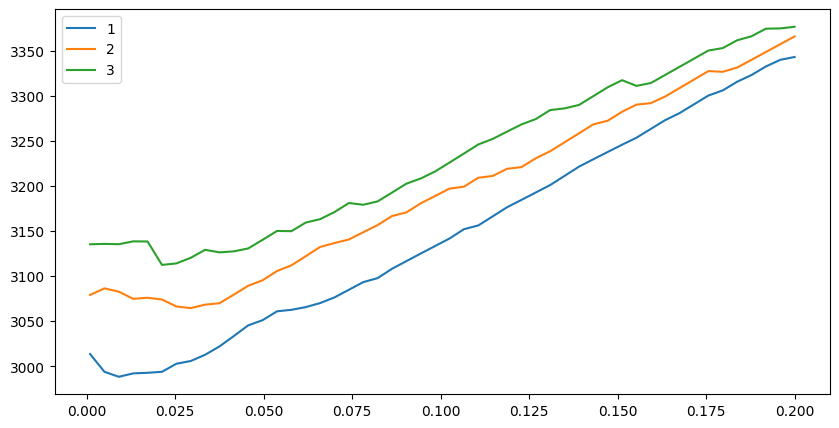

In [50]:
d = 10
As = gen_local_change(10,0.6)


rnd = np.random.RandomState(10)

X1 = rnd.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 80)
X2 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 40)
X3 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 30)

X = np.vstack([X1,X2,X3])

alphas = np.linspace(0.001,0.2, 50)
kappas = [0.01, 0.05, 0.1]
AICs = np.empty((len(kappas), len(alphas)))

for k_cnt, kappa in enumerate(kappas):
    for a_cnt, alpha in enumerate(alphas):
        dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = 50, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

        thetas = dg_opt1.theta
        liks = log_lik_all(50, thetas, X, 'gaussian')
        nr_params_val = find_nr_params(thetas, 'gaussian')
        AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, AICs[0], label = 1)
ax.plot(alphas, AICs[1], label = 2)
ax.plot(alphas, AICs[2], label = 3)
ax.legend()

In [51]:


B = scipy.stats.bernoulli.rvs(p = 0.5, size = (45))   

reg_matrix = np.zeros((3,d,d))
for h in range(1):
    np.fill_diagonal(reg_matrix[h],0)
    reg_matrix[h][np.triu_indices(d,1)] = B*999999
    reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = 30, max_iter = 10000, lamda = reg_matrix, kappa = kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)




In [54]:
def plot_aic(graph_sampling_testing):
    
    X = graph_sampling_testing['X'] #np.vstack([X1,X2,X3])

    alphas = graph_sampling_testing['alphas']# np.linspace(0.01,0.5, 50)
    kappas = graph_sampling_testing['kappas'] #[0.01, 0.05, 0.1]
    AICs = np.empty((len(kappas), len(alphas)))

    for k_cnt, kappa in enumerate(kappas):
        for a_cnt, alpha in enumerate(alphas):
            dg_opt1 = dg.dygl_inner_em(graph_sampling_testing['X'], obs_per_graph = 50, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
            dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

            thetas = dg_opt1.theta
            liks = log_lik_all(50, thetas, X, 'gaussian')
            nr_params_val = find_nr_params(thetas, 'gaussian')
            AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))


    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(alphas, AICs[0], label = 1)
    ax.plot(alphas, AICs[1], label = 2)
    ax.plot(alphas, AICs[2], label = 3)
    ax.legend()



def plot_prob_per_it(graph_sampling_testing, k_idx):
    nr_ce_it = graph_sampling_testing['p_distribution'].shape[3]
    # For binomial
    fig, ax = plt.subplots(20,3, figsize = (15,90))
    for i in range(20):
        for h in range(3):
            for k in [k_idx]:
                for a in range(len(graph_sampling_testing['alphas'])):
                    ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]), graph_sampling_testing['p_distribution'][k,a,h,:,i], label = f'alpha {graph_sampling_testing["alphas"][a]}')
                    #A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
                    #A_est[np.abs(A_est)<1e-3] = 0
                    #ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_est[i]))]*61, color = 'orange')
            A_true = graph_sampling_testing['As'][h][np.triu_indices(10,1)]
            ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_true[i]))]*nr_ce_it, color = 'black')
            #ax[i,h].set_xlabel('Iteration')
            ax[i,h].set_ylabel('p')
            ax[i,h].set_ylim((-0.1,1.1))
            ax[i,h].set_title(f"A_ij = {np.round(graph_sampling_testing['As'][h][np.triu_indices(10,1)][i],2)}")
        ax[i,2].legend(bbox_to_anchor = (1.1,1.1))


def plot_prob_per_it_multiple_models(args, labels,  a_idx, k_idx):
    nr_ce_it = args[0]['p_distribution'].shape[3]
    # For binomial
    fig, ax = plt.subplots(20,3, figsize = (15,90))
    for i in range(20):
        for h in range(3):
            for j in range(len(args)):
                ax[i,h].plot(range(args[j]['p_distribution'].shape[3]), args[j]['p_distribution'][k_idx,a_idx,h,:,i], label = labels[j])

            A_true = args[0]['As'][h][np.triu_indices(10,1)]
            ax[i,h].plot(range(args[0]['p_distribution'].shape[3]),[1-np.abs(np.sign(A_true[i]))]*nr_ce_it, color = 'black')
            #ax[i,h].set_xlabel('Iteration')
            ax[i,h].set_ylabel('p')
            ax[i,h].set_ylim((-0.1,1.1))
            ax[i,h].set_title(f"A_ij = {np.round(args[0]['As'][h][np.triu_indices(10,1)][i],2)}")
        ax[i,2].legend(bbox_to_anchor = (1.1,1.1))


def plot_auc(graph_sampling_testing):
    from sklearn import metrics
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    i = 1

    for j in range(len(graph_sampling_testing['alphas'])):
        y = np.concatenate((np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)]))))
        pred = np.concatenate(( graph_sampling_testing['p_distribution'][i,j,0,-1],  graph_sampling_testing['p_distribution'][i,j,1,-1],  graph_sampling_testing['p_distribution'][i,j,2,-1]))

        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
        auc = metrics.roc_auc_score(1-y, pred)

        ax.plot(fpr, tpr,label="alpha = " + str(np.round(graph_sampling_testing['alphas'][j],2)) + ", auc="+str(np.round(auc,2)))
        ax.legend()

    ax.plot([0,1], [0,1],color = 'black')


def p_vs_abs_edge(graph_sampling_testing, as_test = [1,3, 6]):
    fig, ax = plt.subplots(len(as_test),2, figsize = (15,20))
    for cnt, a in enumerate(as_test): #range(len(graph_sampling_testing['alphas'])):
        for k in range(2):
            ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 0,-1,:],np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)]), label = '1', color = 'blue')
            ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 1,-1,:],np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)]), label = '2', color = 'blue' )
            ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 2,-1,:],np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)]), label = '3', color = 'blue' )
            ax[cnt,k].set_ylabel("Absolute edge")
            ax[cnt,k].set_xlabel("Probability")
            ax[cnt,k].set_xlim((0,1))
            ax[cnt,k].set_title(f"alpha {np.round(graph_sampling_testing['alphas'][a],2)} kappa {graph_sampling_testing['kappas'][k]}")
            ax[cnt,k].legend()
            ax[cnt,k].set_ylim((-0.1,2))
            ax[cnt,k].set_xlim((-0.05,1.05))



def p_vs_abs_edge_kde(graph_sampling_testing, as_test = [1, 3, 6]):
    from scipy.stats import gaussian_kde
    fig, ax = plt.subplots(len(as_test),2, figsize = (15,15))
    for cnt, a in enumerate(as_test): #range(len(graph_sampling_testing['alphas'])):
        for k in range(2):
            x = np.concatenate((1-graph_sampling_testing['p_distribution'][k, a, 0,-1,:], 1-graph_sampling_testing['p_distribution'][k, a, 1,-1,:], 1-graph_sampling_testing['p_distribution'][k, a, 2,-1,:]))
            y = np.concatenate((np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)]), np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)]), np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)])))
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)

            ax[cnt,k].scatter(x, y, c=z, s=100)
            ax[cnt,k].set_ylabel("Absolute edge")
            ax[cnt,k].set_xlabel("Probability")
            ax[cnt,k].set_xlim((0,1))
            ax[cnt,k].set_title(f"alpha {np.round(graph_sampling_testing['alphas'][a],2)} kappa {graph_sampling_testing['kappas'][k]}")
            ax[cnt,k].legend()
            ax[cnt,k].set_ylim((-0.1,2))
            ax[cnt,k].set_xlim((-0.05,1.05))


# Multiple

In [ ]:
print(np.round(gst_cai_08['As'][0],2))

In [55]:
with open(f'../data/GraphHypTest/unknown_cp_0.6_50_cai_xs_xs_False_tp_0.8.pkl', 'rb') as handle:
    gst_cai_08 = pickle.load(handle)
with open(f'../data/GraphHypTest/unknown_cp_0.6_50_cai_xs_xs_False_tp_0.9.pkl', 'rb') as handle:
    gst_cai_09 = pickle.load(handle)
with open(f'../data/GraphHypTest/unknown_cp_0.6_50_zero-one_xs_xs_False_tp_0.8.pkl', 'rb') as handle:
    gst_zo_08 = pickle.load(handle)
with open(f'../data/GraphHypTest/unknown_cp_0.6_50_zero-one_xs_xs_False_tp_0.9.pkl', 'rb') as handle:
    gst_zo_09 = pickle.load(handle)

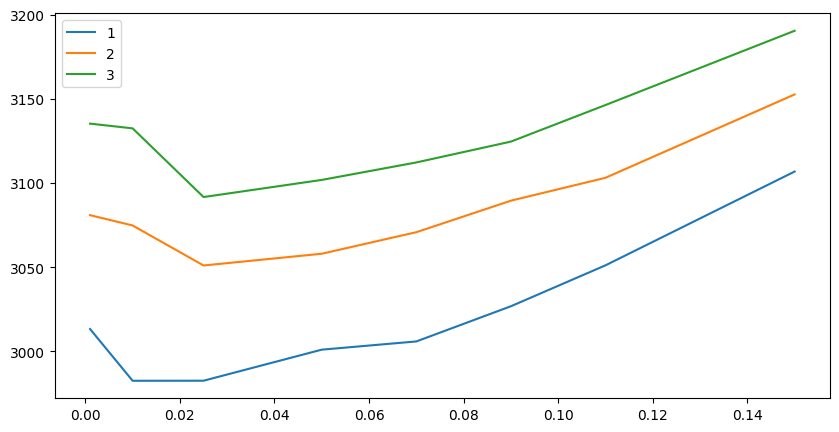

In [56]:
plot_aic(gst_cai_08)
#plot_aic(gst_cai_09)
#plot_aic(gst_zo_08)
#plot_aic(gst_zo_09)

In [10]:
print(np.round(gst_cai_08['As'][0],2))
print(np.round(gst_cai_08['As'][1],2))

[[2.95 0.   0.   0.51 0.91 0.25 0.41 0.   0.   0.  ]
 [0.   2.95 0.   0.81 0.63 0.87 0.8  0.19 0.89 0.54]
 [0.   0.   2.95 0.11 0.23 0.   0.82 0.86 0.01 0.51]
 [0.51 0.81 0.11 2.95 0.   0.   0.52 0.7  0.   0.97]
 [0.91 0.63 0.23 0.   2.95 0.   0.61 0.5  0.05 0.28]
 [0.25 0.87 0.   0.   0.   2.95 0.67 0.76 0.24 0.73]
 [0.41 0.8  0.82 0.52 0.61 0.67 2.95 0.   0.04 0.  ]
 [0.   0.19 0.86 0.7  0.5  0.76 0.   2.95 0.94 0.14]
 [0.   0.89 0.01 0.   0.05 0.24 0.04 0.94 2.95 0.24]
 [0.   0.54 0.51 0.97 0.28 0.73 0.   0.14 0.24 2.95]]
[[ 2.95  0.06  0.    0.51  0.91  0.    0.41  0.    0.   -0.12]
 [ 0.06  2.95 -0.95  0.81  0.63  0.87  0.8  -0.69  0.1   0.54]
 [ 0.   -0.95  2.95  0.11  0.91  0.    0.82  0.86  0.01 -0.29]
 [ 0.51  0.81  0.11  2.95  0.   -0.77 -0.92  0.7   0.    0.  ]
 [ 0.91  0.63  0.91  0.    2.95 -0.02  0.61 -0.13  0.05  0.28]
 [ 0.    0.87  0.   -0.77 -0.02  2.95  0.67 -0.25  0.24  0.73]
 [ 0.41  0.8   0.82 -0.92  0.61  0.67  2.95  0.    0.04 -0.86]
 [ 0.   -0.69  0.86  0.7  -0

probability with iteration

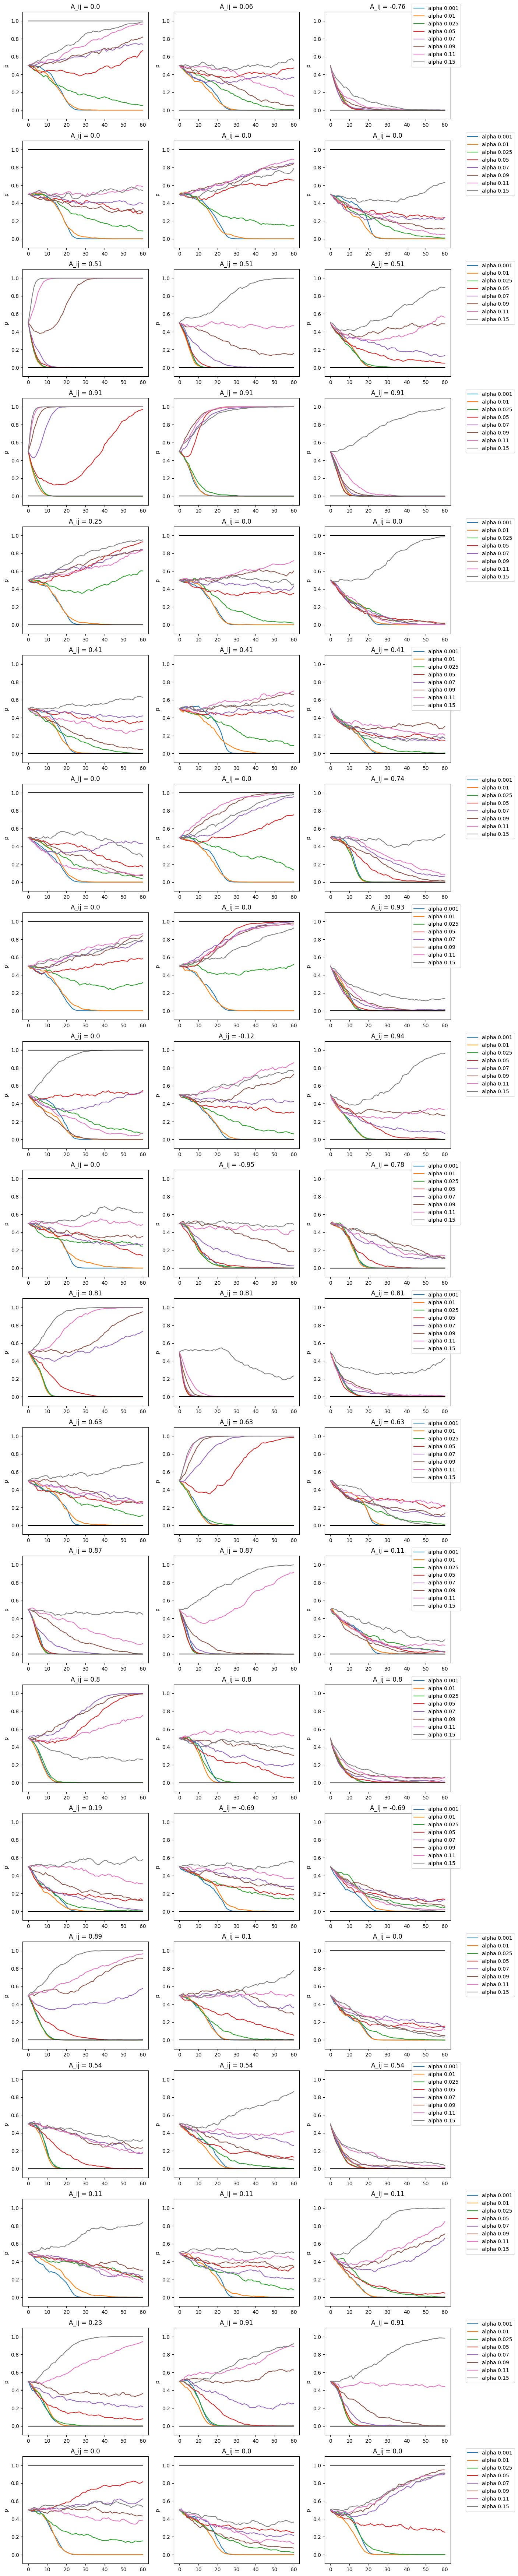

In [19]:
plot_prob_per_it(gst_cai_08,0)


In [20]:
gst_cai_08['alphas']

[0.001, 0.01, 0.025, 0.05, 0.07, 0.09, 0.11, 0.15]

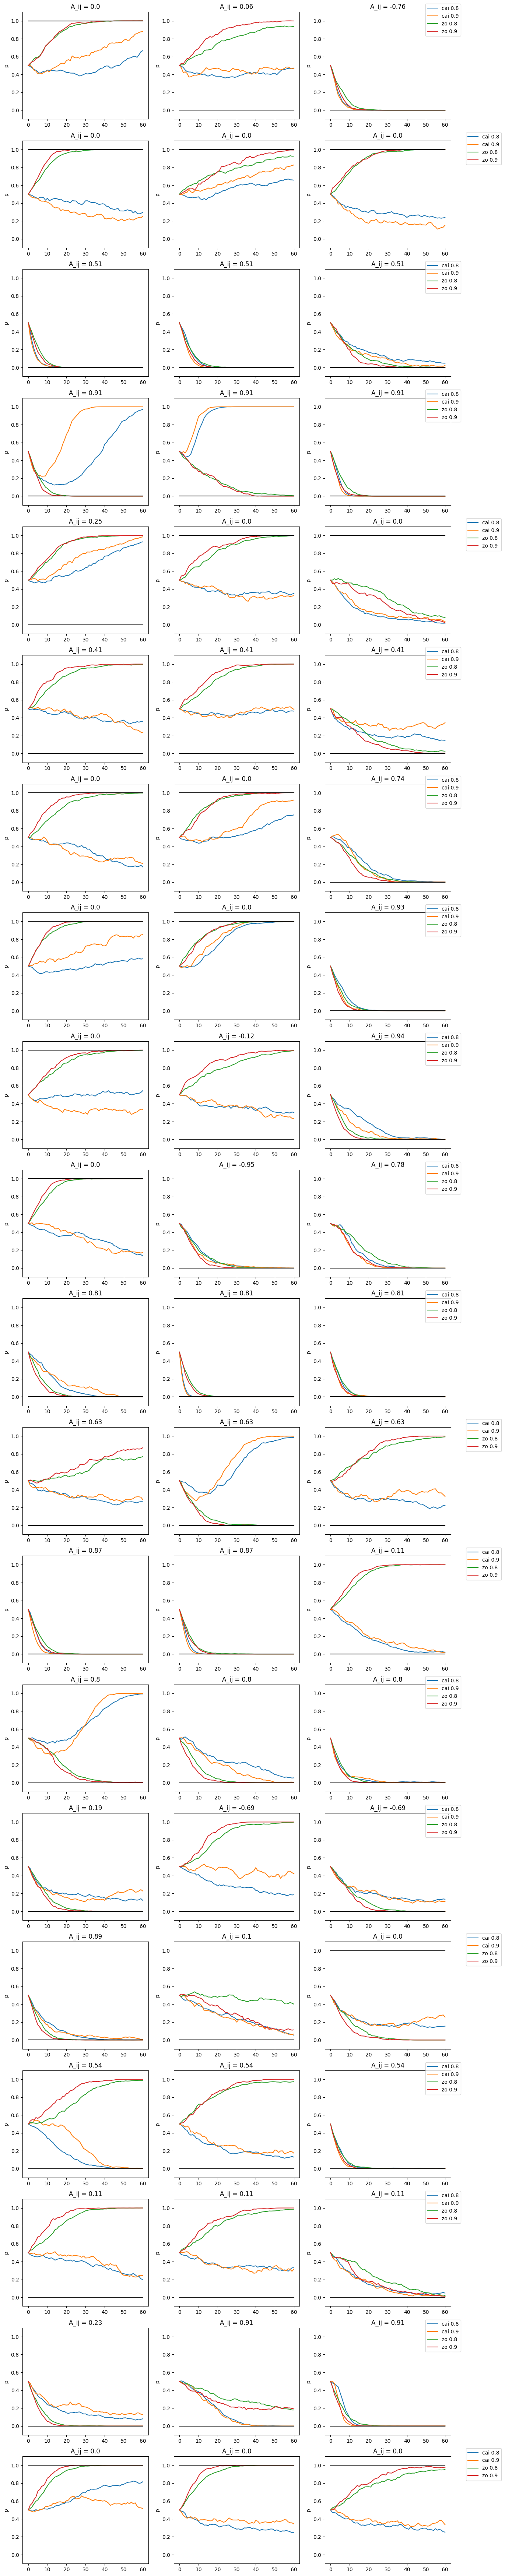

In [25]:
plot_prob_per_it_multiple_models([gst_cai_08, gst_cai_09, gst_zo_08, gst_zo_09], ['cai 0.8', 'cai 0.9', 'zo 0.8', 'zo 0.9'], 3, 0)

<AxesSubplot: >

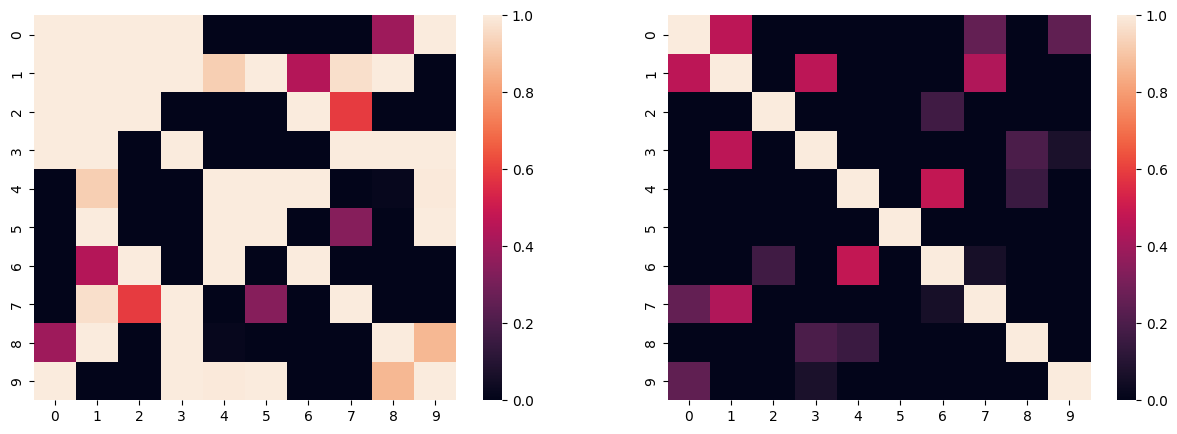

In [79]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.heatmap(1-P[0,4,0], ax = ax[0])
sns.heatmap(np.abs(As[0])/np.max(np.abs(As[0])), ax = ax[1])

histogram p

In [49]:
graph_sampling_testing['p_distribution'][0,4,h,-1]

array([1.35875480e-33, 2.38743408e-22, 1.00000000e+00, 3.35499985e-32,
       3.84743216e-13, 5.41452187e-18, 1.00000000e+00, 7.30993150e-01,
       1.00000000e+00, 9.99999864e-01, 7.55146433e-29, 7.75524045e-39,
       1.47370767e-31, 5.78154098e-01, 2.91911925e-18, 1.00000000e+00,
       1.00000000e+00, 2.96730360e-29, 3.20973410e-28, 1.00000000e+00,
       1.00000000e+00, 9.99987558e-01, 5.72751032e-29, 1.00000000e+00,
       2.41527030e-34, 1.16659597e-34, 1.00000000e+00, 4.68539509e-02,
       7.85681267e-37, 1.29506131e-16, 9.60257083e-01, 4.22745126e-32,
       1.00000000e+00, 3.45662548e-18, 5.15098502e-07, 1.00000000e+00,
       5.34850538e-24, 1.00000000e+00, 6.67577077e-23, 1.05505657e-15,
       8.94376786e-01, 1.00000000e+00, 1.00000000e+00, 9.87280872e-01,
       1.00000000e+00])

<AxesSubplot: ylabel='Density'>

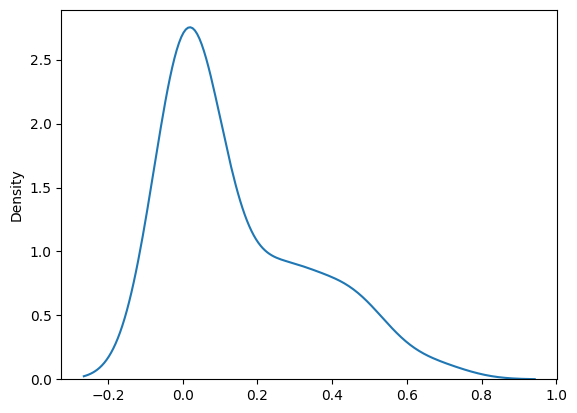

In [27]:
sns.kdeplot(graph_sampling_testing['p_distribution'][0,4,h,-1])

AUC

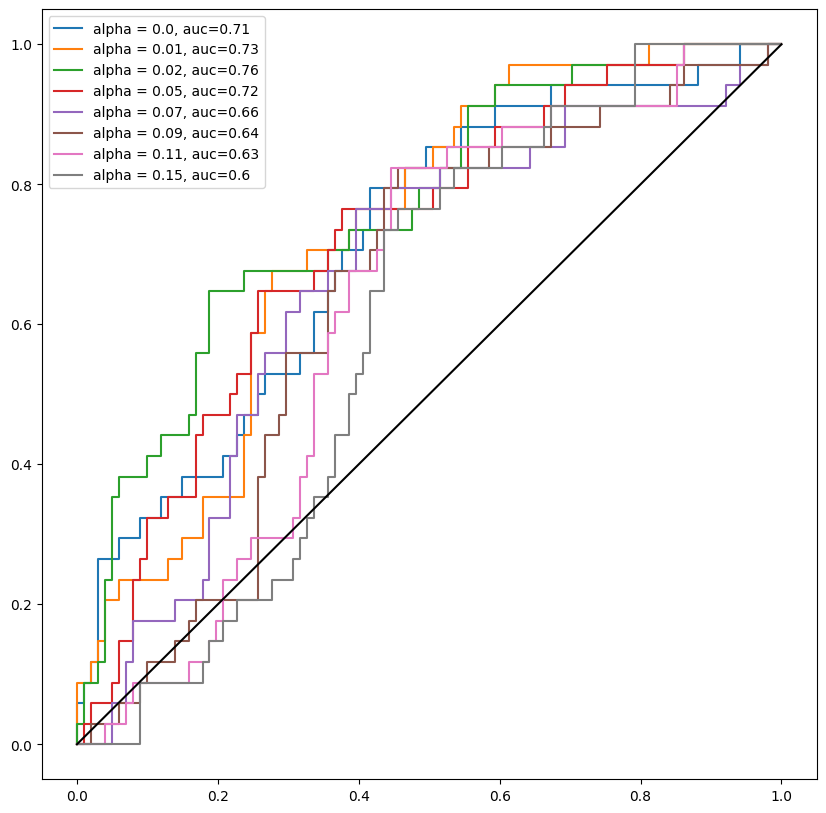

In [34]:
plot_auc(gst_zo_08)

P vs absolute edge

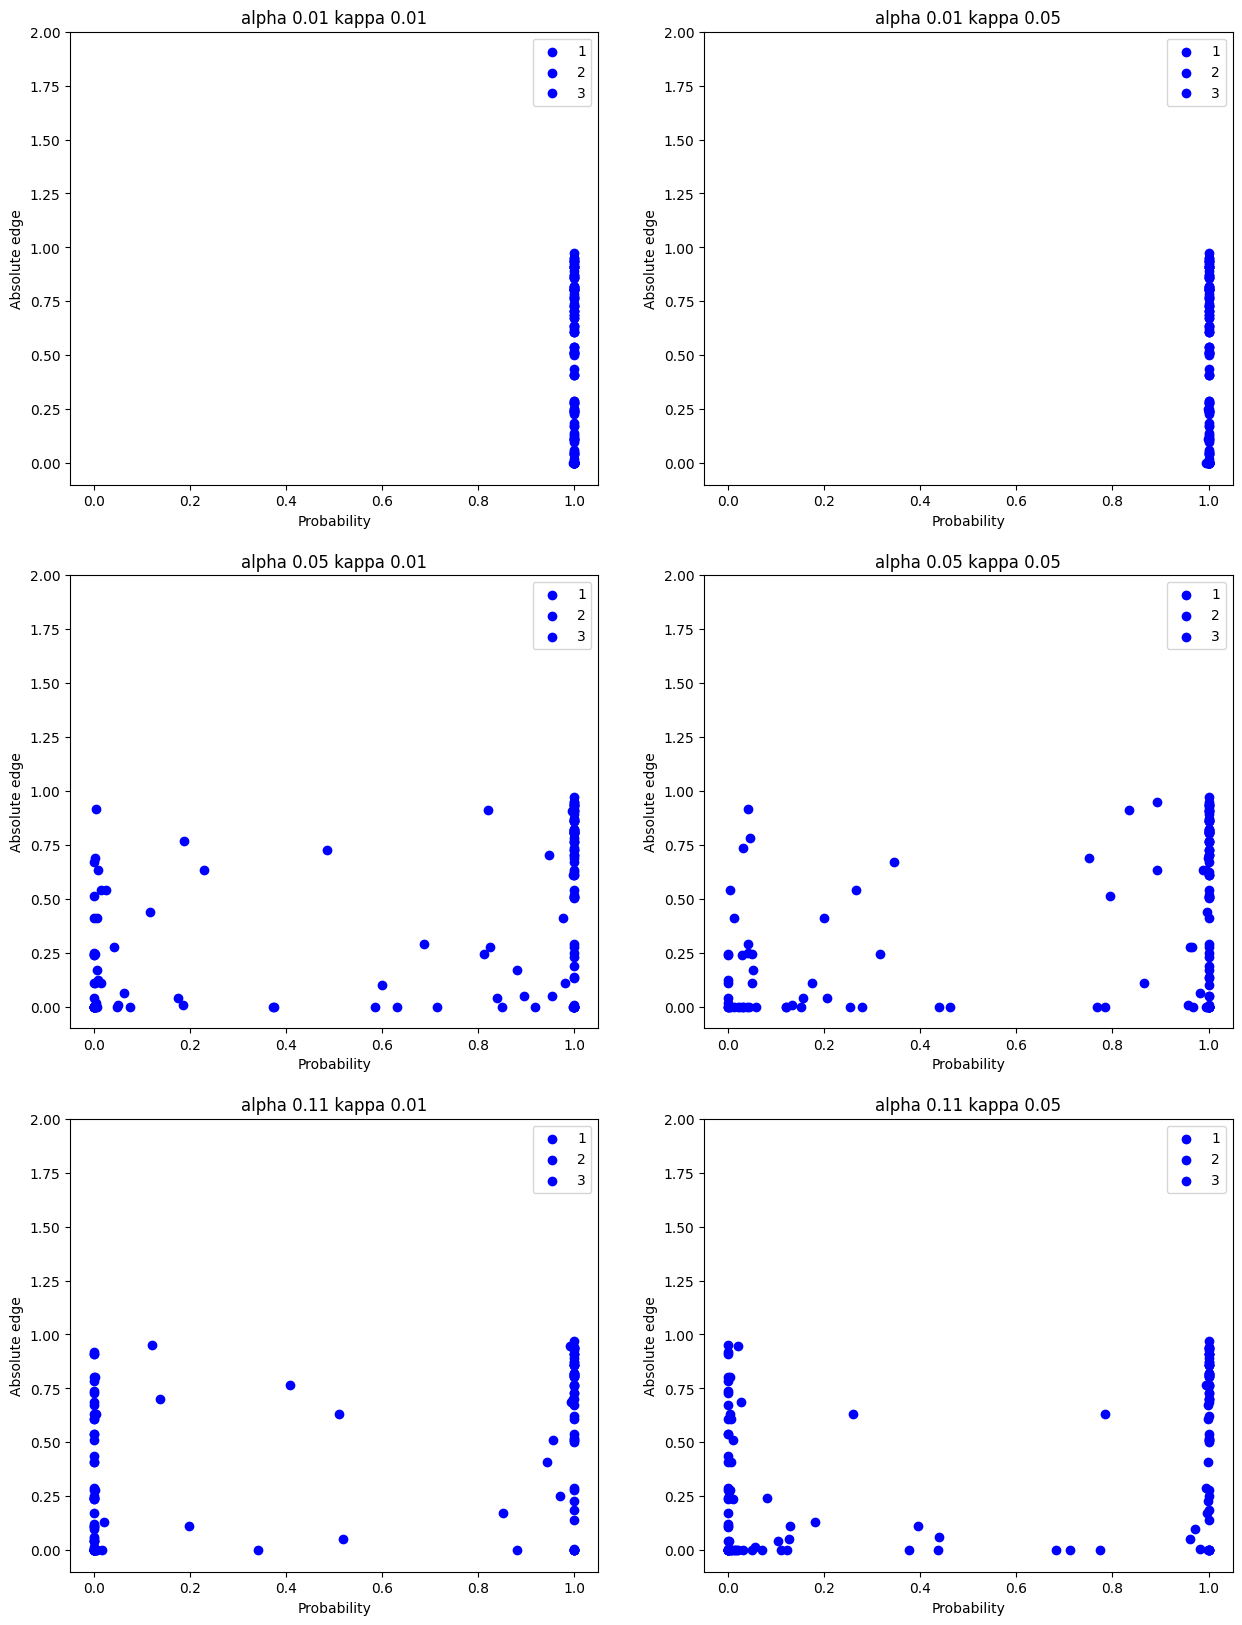

In [41]:
p_vs_abs_edge(gst_zo_08)

Plot P with time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


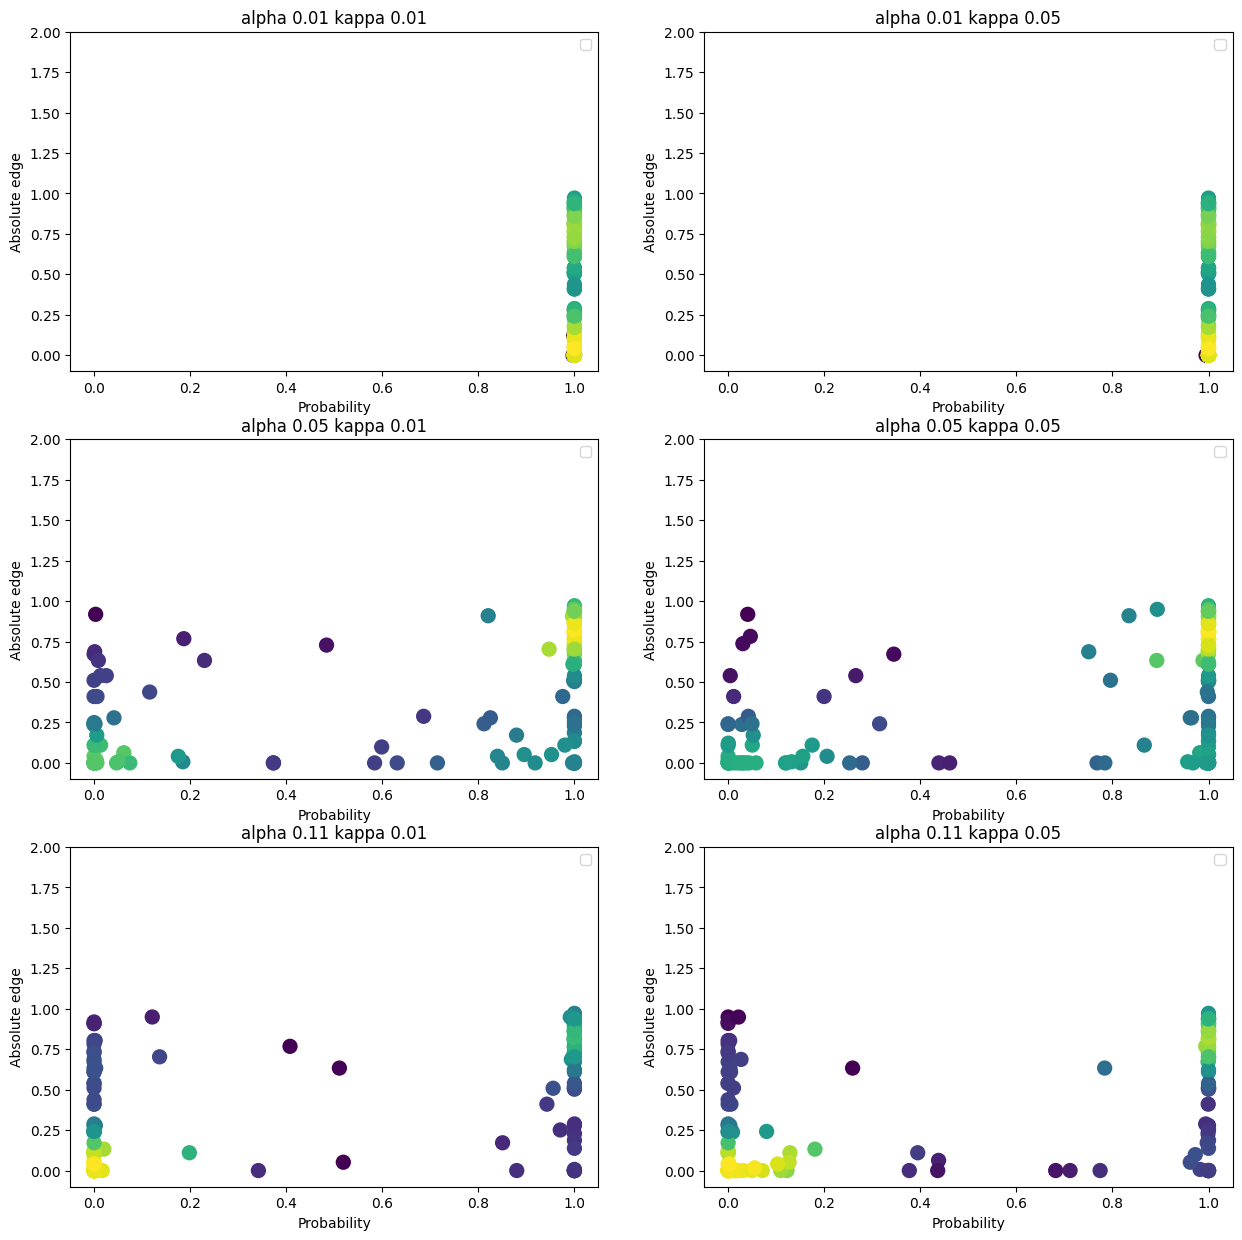

In [42]:
p_vs_abs_edge_kde(gst_zo_08)

Thetas simulated - One edge

C:\Users\User\AppData\Local\Temp\ipykernel_17284\862251596.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
C:\Users\User\AppData\Local\Temp\ipykernel_17284\862251596.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')


Text(0.5, 1.0, 'kappa 0.05')

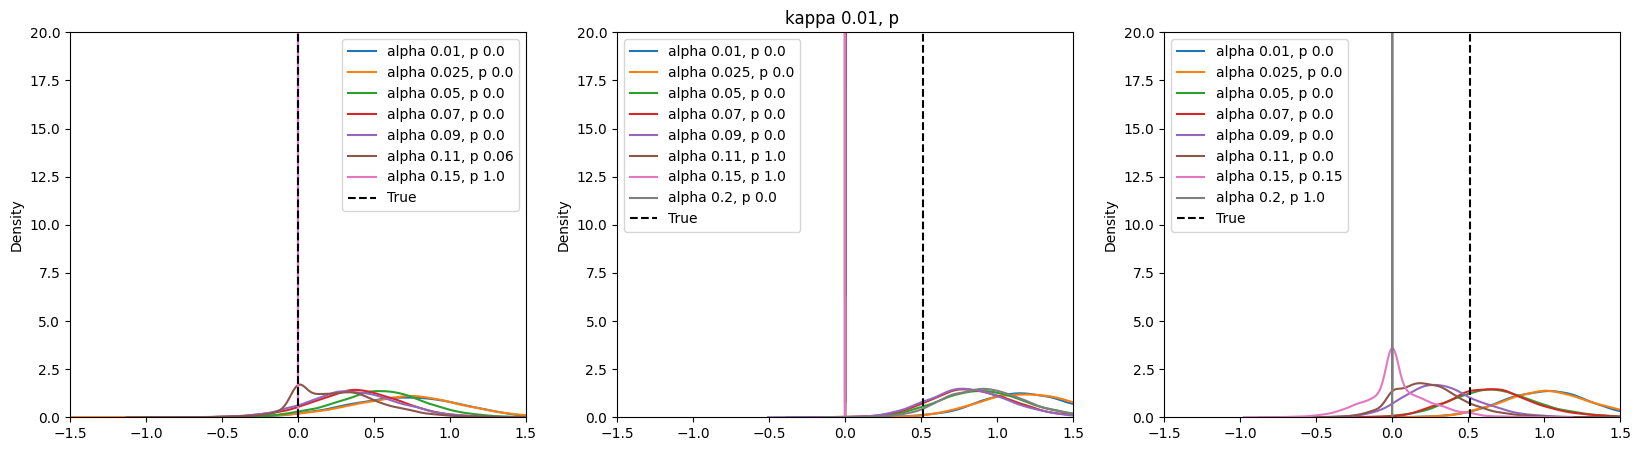

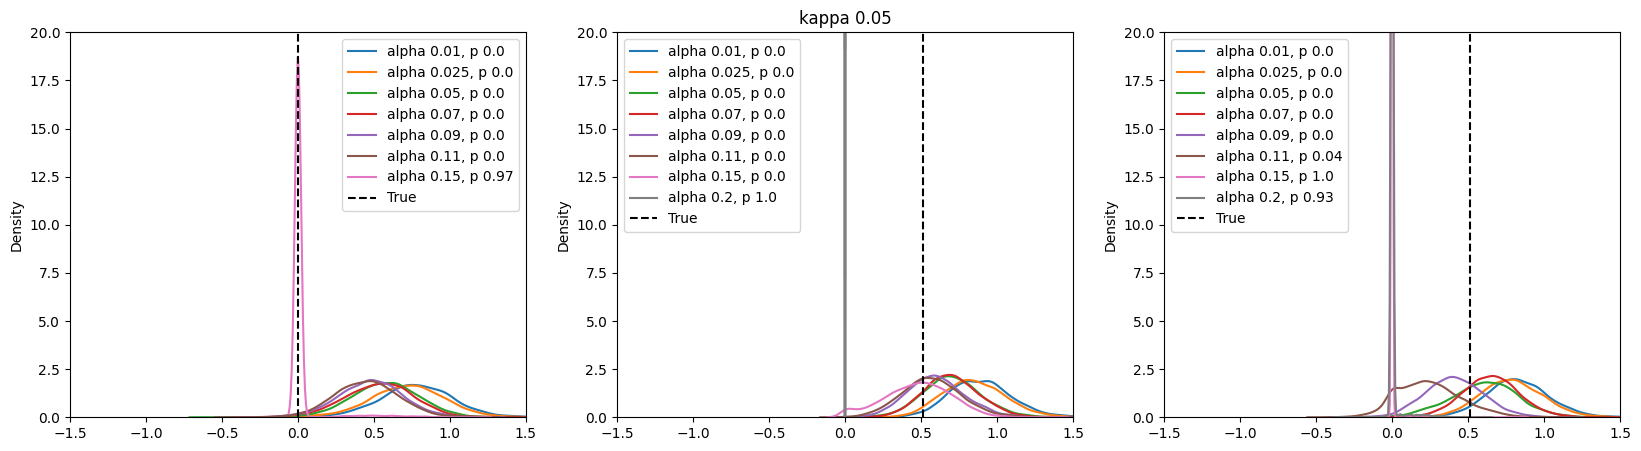

In [74]:
i = 0
j = 2

xlim = (-1.5, 1.5)

As = graph_sampling_testing['As']
fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 0
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
    #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].legend()
    ax[h].set_xlim(xlim)
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}, p ')

As = graph_sampling_testing['As']
fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 1
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
    #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].legend()
    ax[h].set_xlim(xlim)
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

# As = graph_sampling_testing['As']
# fig, ax = plt.subplots(1,3, figsize = (20, 5))
# k = 2
# for h in range(2):
#     for a in range(len(graph_sampling_testing['alphas'])):
#         theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
#         sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
#     #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
#     ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
#     ax[h].set_ylim((0,20))
#     ax[h].legend()
#     ax[h].set_xlim(xlim)
# ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

Simulated thetes - CI

In [49]:
graph_sampling_testing['thetas_sim'].shape

(3, 10, 5000, 3, 10, 10)

In [50]:
np.mean(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )

array([[ 1.27673544e+00,  2.04108630e-01,  1.17005400e-01,
         3.03042581e-02, -7.87715625e-04,  2.02458884e-03,
        -3.55099515e-04,  9.67700906e-04, -1.07423124e-02,
        -9.97170111e-04],
       [ 2.04108630e-01,  1.20198445e+00, -2.86272436e-02,
        -4.20387084e-01,  1.33104548e-01, -1.63707688e-03,
        -7.75110561e-02,  4.83867630e-01,  1.08676867e-01,
        -2.05706317e-03],
       [ 1.17005400e-01, -2.86272436e-02,  1.31563994e+00,
        -1.63191598e-01,  7.21890324e-04, -7.50177082e-03,
        -2.91484953e-02, -1.85059364e-03,  6.06507348e-02,
         6.75042271e-03],
       [ 3.03042581e-02, -4.20387084e-01, -1.63191598e-01,
         1.12100793e+00,  5.00763556e-02, -5.67598063e-02,
        -2.41842386e-02,  2.32846670e-02,  1.10900240e-01,
         2.94145465e-02],
       [-7.87715625e-04,  1.33104548e-01,  7.21890324e-04,
         5.00763556e-02,  1.77982671e+00, -3.64548756e-04,
         9.32310352e-02, -6.70126855e-04, -6.75020593e-02,
        -1.

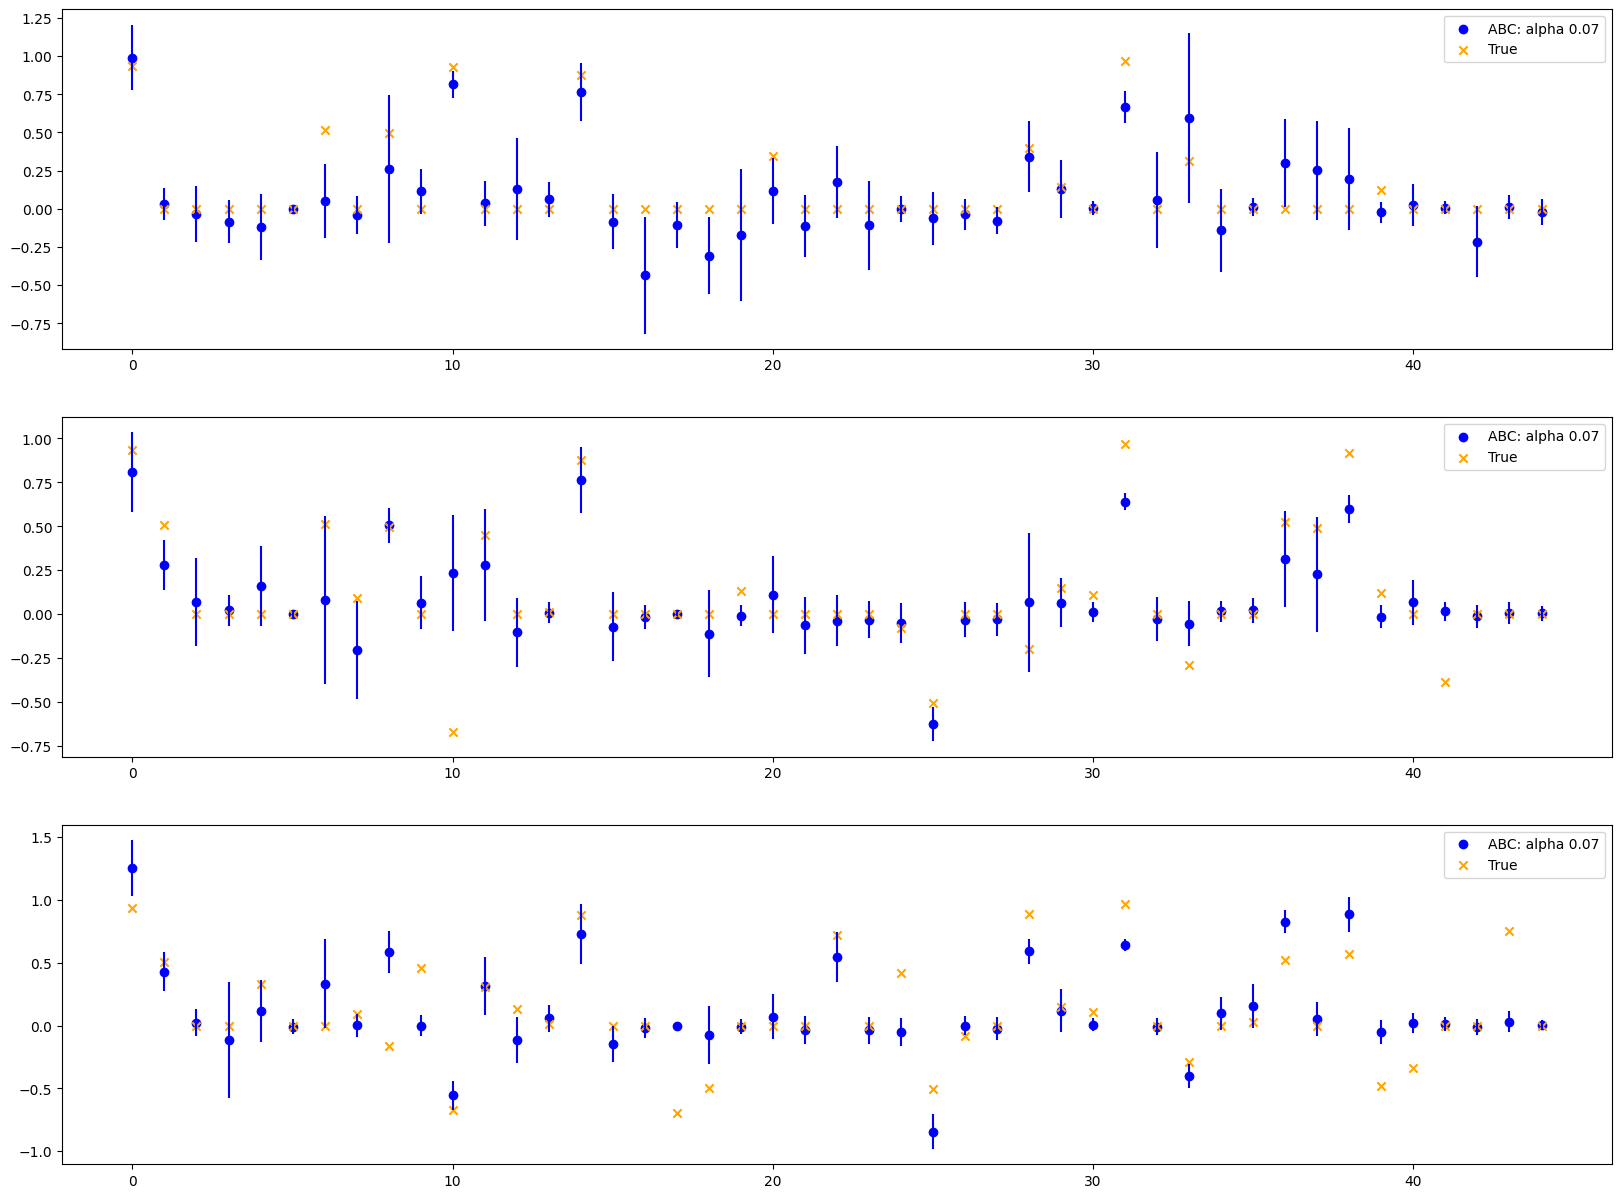

In [58]:

fig, ax = plt.subplots(3,1, figsize = (20,15))
d = 10
colors = ['blue', 'red', 'green', 'pink', 'yellow']

#for a in range(len(alphas)):
a = 3
k = 0
for h in range(3):
    #theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
    #theta_est[np.abs(theta_est)<1e-3] = 0
    #theta_u = theta_est[np.triu_indices(d,1)]
    mean_u = np.mean(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )[np.triu_indices(d,1)]
    std_u = np.std(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )[np.triu_indices(d,1)]
    A_true_u = graph_sampling_testing['As'][h].copy()[np.triu_indices(d,1)]


    ax[h].scatter(0, mean_u[0], label =f'ABC: alpha {np.round(graph_sampling_testing["alphas"][a],2)}', color = 'blue')
    #ax[h].scatter(0, theta_u[0], label =f'Dygl: alpha {np.round(graph_sampling_testing["alphas"][a],2)}', color = 'black')
    ax[h].scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
    ax[h].errorbar(0, mean_u[0], 2*std_u[0], color = 'blue')

    ax[h].legend(bbox_to_anchor = (1,1))

    for i in range(1, 45):
        ax[h].scatter(i, mean_u[i], label =f'alpha {np.round(graph_sampling_testing["alphas"][a],2)} ABC', color = 'blue')
        #ax[h].scatter(i, theta_u[i], label =f'alpha {np.round(graph_sampling_testing["alphas"][a],2)}  Dygl', color = 'black')
        ax[h].scatter(i, A_true_u[i], marker = 'x', label ='True', color = 'orange')
        ax[h].errorbar(i, mean_u[i], 2*std_u[i], color = 'blue')

simulated thetas - kde edge paths

In [89]:
graph_sampling_testing['thetas_sim'].shape

(3, 4, 30, 1000, 3, 10, 10)

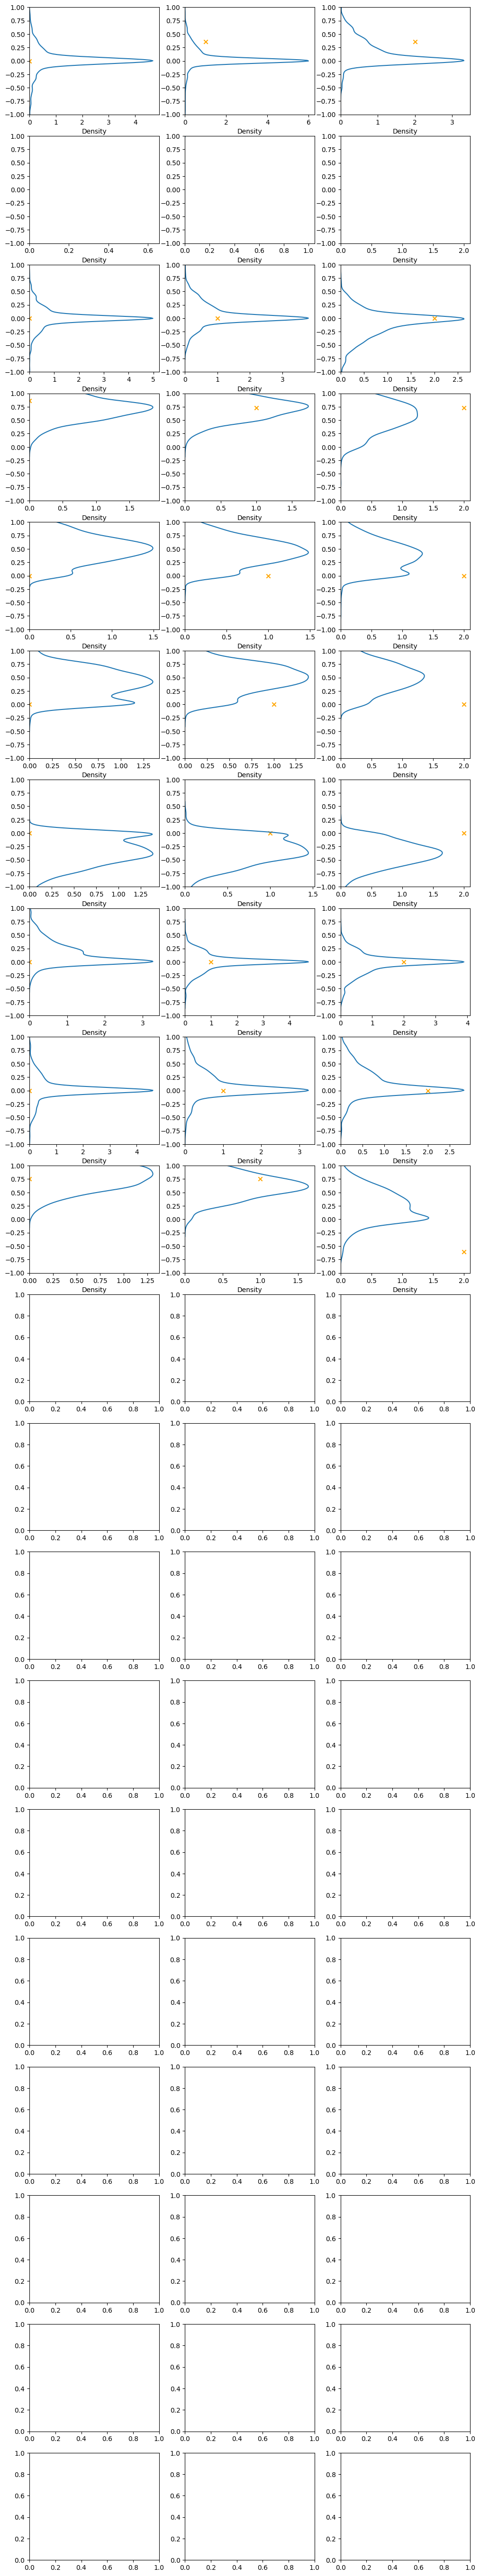

In [92]:




k = 0
a = 1

theta_est = graph_sampling_testing['thetas'][k,a].copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0
#std_u = np.std(thetas_sim[k,a,:], axis = 1 )

fig, ax = plt.subplots(20,3, figsize = (12,70))
n_i = 1
for n_j in range(0,10):
    for h in range(3):
        #ax[n_j,h].scatter([h], theta_est[h,n_i,n_j], label ='Estimate', color = 'black')
        ax[n_j,h].scatter([h], As[h,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
        sns.kdeplot(y = graph_sampling_testing['thetas_sim'][k,a,-1,:,h,n_i,n_j], ax = ax[n_j,h])
        ax[n_j,h].set_ylim((-1,1))
    #ax.legend()

Test graph estimation

In [48]:
graph_sampling_testing['X'].shape

(90, 10)

In [76]:
dg_opt1 = dg.dygl_inner_em(graph_sampling_testing['X'], obs_per_graph = 30, max_iter = 10000, lamda = 0.01, kappa =0.01, tol = 1e-4)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

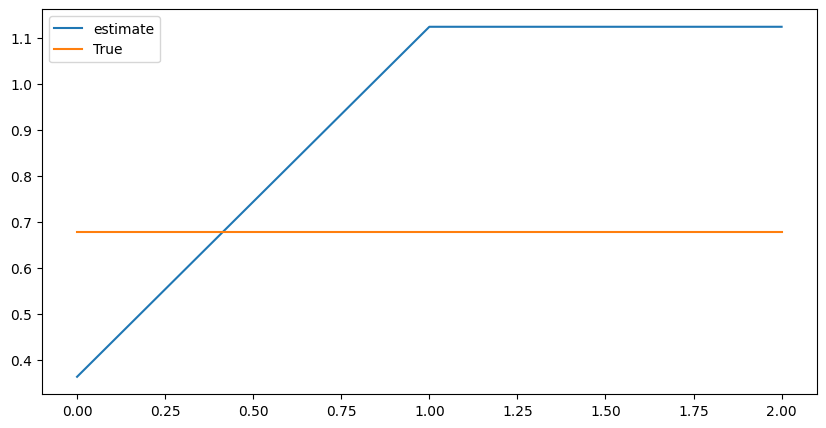

In [78]:
i = 0
j = 6

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(dg_opt1.theta[:,i,j], label = 'estimate')
ax.plot(graph_sampling_testing['As'][:,i,j],label =  'True')
ax.legend()

# Single

In [45]:
# For binomial

def plot_singles(args, labels):
    fig, ax = plt.subplots(20,3, figsize = (15,90))
    for i in range(20):
        for h in range(3):
            freq_boot = np.mean(np.abs(np.sign(args[0]['thetas_sim'][:,h])), axis = 0)[np.triu_indices(d,1)]
            lll = args[0]['p_distribution'].shape[1]
            ax[i,h].plot(range(lll), [1-freq_boot[i]]*lll, label = f'frequentist bootstrap', color = 'brown', linestyle = '--')

        for h in range(3):
            for j in range(len(args)):
                ax[i,h].plot(range(args[j]['p_distribution'].shape[1]), args[j]['p_distribution'][h,:,i], label = labels[j])
            A_true = args[0]['As'][h][np.triu_indices(10,1)]
            ax[i,h].plot(range(args[0]['p_distribution'].shape[1]),[1-np.abs(np.sign(A_true[i]))]*args[0]['p_distribution'].shape[1], color = 'black')
            #ax[i,h].set_xlabel('Iteration')
            ax[i,h].set_ylabel('p')
            ax[i,h].set_ylim((-0.1,1.1))
            ax[i,h].set_title(f"A_ij = {np.round(args[0]['As'][h][np.triu_indices(10,1)][i],2)}")
        ax[i,2].legend()


In [47]:
with open(f'../data/GraphHypTest/single_sim_gaussian_False_cai_xs_xs_ew_0.6.pkl', 'rb') as handle:
    gst0 = pickle.load(handle)
    gst0['p_distribution'] = gst0['p']
    gst0['alphas'] = [0.05]
    gst0['kappas'] = [0.05]
    gst0['As'] = gen_local_change(10,0.3)


with open(f'../data/GraphHypTest/single_sim_gaussian_False_zero-one_xs_xs_ew_0.6.pkl', 'rb') as handle:
    gst1 = pickle.load(handle)
    gst1['p_distribution'] = gst1['p']
    gst1['alphas'] = [0.05]
    gst1['kappas'] = [0.05]
    gst1['As'] = gen_local_change(10,0.3)

with open(f'../data/GraphHypTest/single_sim_gaussian_False_cai_xs_xs_ew_0.3.pkl', 'rb') as handle:
    gst2 = pickle.load(handle)
    gst2['p_distribution'] = gst2['p']
    gst2['alphas'] = [0.05]
    gst2['kappas'] = [0.05]
    gst2['As'] = gen_local_change(10,0.3)




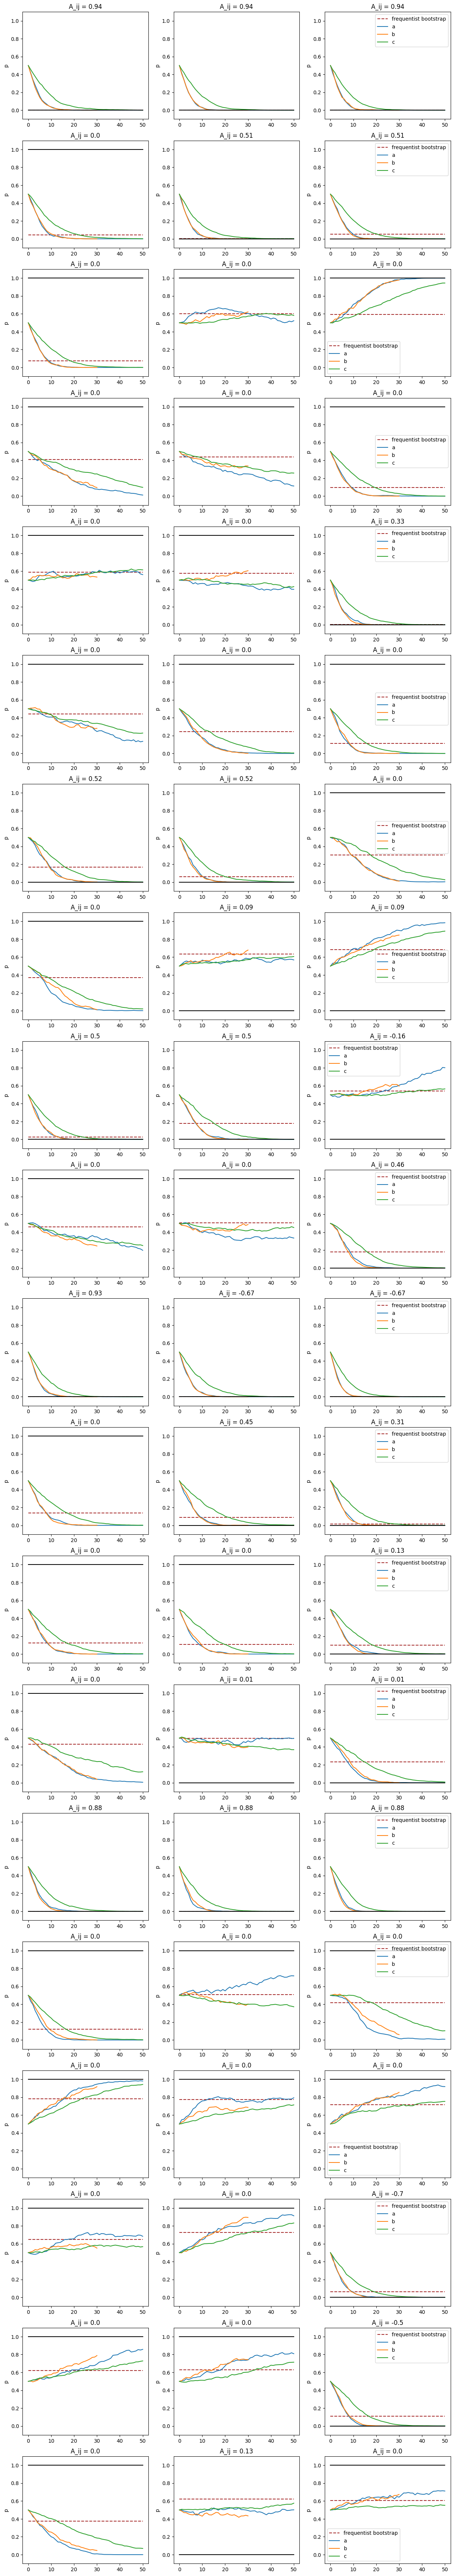

In [48]:
plot_singles([gst0, gst1, gst2], ['a', 'b', 'c'])